## Homework 4


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold


%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 22:59:15--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.10’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.06s   

2021-10-03 22:59:16 (2.93 MB/s) - ‘CreditScoring.csv.10’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [9]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [10]:
print(df.dtypes)

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object


In [11]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)
numerical.remove('default')

Categorical Variables:
home, martial, records, job

Numerical Variables:
Seniority, time, age, expenses, income, assets, dept, amount, price, default

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [12]:
df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)


df_train_full.reset_index(drop=True)
df_test.reset_index(drop=True)
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)

y_train_full = df_train_full.default.values
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train_full['default']
del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [13]:
for feature in numerical:
    print("Feature name:", feature)
    auc = roc_auc_score(y_train, df_train[feature])
    if auc< 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    print("AUC:", auc)

Feature name: seniority
AUC: 0.7093778624491943
Feature name: time
AUC: 0.5608662489595051
Feature name: age
AUC: 0.5732933272499939
Feature name: expenses
AUC: 0.5009184217217011
Feature name: income
AUC: 0.682006666132633
Feature name: assets
AUC: 0.6486042567122802
Feature name: debt
AUC: 0.5047829675783548
Feature name: amount
AUC: 0.5910773431595518
Feature name: price
AUC: 0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt


Answer:
* Seniority: 0.7093778624491943
* Time : 0.5608662489595051
* Income: 0.682006666132633
* Debt: 0.5047829675783548

**Seniority** has the highest AUC

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [14]:
features_selected = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

train_dict = df_train[features_selected].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [15]:
X_val = dv.transform(df_val[features_selected].to_dict(orient='records'))
y_pred = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred).round(3)
print(val_auc)

0.811


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [16]:
scores = []

thresholds = np.arange(0,1,0.01)

for t in thresholds:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

df_scores

,threshold,tp,fp,fn,tn,recall,precision
0,0.00,246,645,0,0,1.00000,0.276094
1,0.01,246,635,0,10,1.00000,0.279228
2,0.02,244,610,2,35,0.99187,0.285714
3,0.03,242,591,4,54,0.98374,0.290516
4,0.04,242,562,4,83,0.98374,0.300995
...,...,...,...,...,...,...,...
95,0.95,0,0,246,645,0.00000,NaN
96,0.96,0,0,246,645,0.00000,NaN
97,0.97,0,0,246,645,0.00000,NaN
98,0.98,0,0,246,645,0.00000,NaN


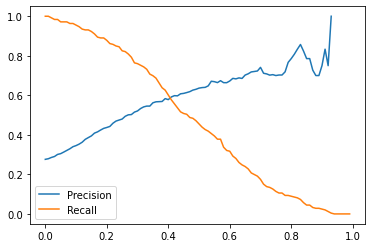

In [17]:
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

Ans: 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [18]:
df_scores['f1_score'] = 2*((df_scores.precision*df_scores.recall)/(df_scores.precision+df_scores.recall))
print(df_scores.iloc[np.where(df_scores.f1_score == df_scores.f1_score.max())])

    threshold   tp   fp  fn   tn    recall  precision  f1_score
32       0.32  183  155  63  490  0.743902    0.54142  0.626712


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

Ans: 0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [19]:
from tqdm import tqdm

n_splits = 5


kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):

    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = y_train_full[train_idx]
    y_val = y_train_full[val_idx]


    train_dict = df_train[features_selected].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    X_val = dv.transform(df_val[features_selected].to_dict(orient='records'))
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (1.0, np.mean(scores), np.std(scores)))

C=1.0 0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

Ans: 0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [20]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):

        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = y_train_full[train_idx]
        y_val = y_train_full[val_idx]


        train_dict = df_train[features_selected].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        X_val = dv.transform(df_val[features_selected].to_dict(orient='records'))
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|███████████▊                                   | 1/4 [00:00<00:02,  1.02it/s]

C=0.01 0.808 +- 0.012


 50%|███████████████████████▌                       | 2/4 [00:01<00:01,  1.01it/s]

C=0.1 0.813 +- 0.014


 75%|███████████████████████████████████▎           | 3/4 [00:02<00:00,  1.01it/s]

C=1 0.814 +- 0.015


100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]

C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

We have the best mean score when C=1 and C=10 and both of them has the lowest std i.e. 0.015. Therefore, the C which leads to the best mean score is 1.

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.